## A7: Multi-Class Model Selection using ROC and Precision-Recall Curves

### Part A: Data Preparation and Baseline

In [1]:
import numpy as np
import pandas as pd

In [2]:
train =pd.read_csv('sat.trn.csv')
train.head()

,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,...,f28,f29,f30,f31,f32,f33,f34,f35,f36,f37
0,92,115,120,94,84,102,106,79,84,102,...,104,88,121,128,100,84,107,113,87,3
1,84,102,106,79,84,102,102,83,80,102,...,100,84,107,113,87,84,99,104,79,3
2,84,102,102,83,80,102,102,79,84,94,...,87,84,99,104,79,84,99,104,79,3
3,80,102,102,79,84,94,102,79,80,94,...,79,84,99,104,79,84,103,104,79,3
4,84,94,102,79,80,94,98,76,80,102,...,79,84,103,104,79,79,107,109,87,3


In [3]:
train.shape

(4435, 37)

In [4]:
test=pd.read_csv('sat.tst.csv')
test.shape

(2000, 37)

In [5]:
from sklearn.preprocessing import StandardScaler

target_col_train = train.columns[-1]
target_col_test  = test.columns[-1]
if target_col_train != target_col_test:
    print("Warning: train/test last-column names differ:", target_col_train, target_col_test)
target_col = target_col_train
print("Assuming target column is:", target_col)


#  Split features/target 
X_train = train.iloc[:, :-1].copy()
y_train = train.iloc[:, -1].copy()
X_test  = test.iloc[:, :-1].copy()
y_test  = test.iloc[:, -1].copy()

print("Feature shapes:", X_train.shape, X_test.shape)
print("Target class counts (train):\n", y_train.value_counts(normalize=False).sort_index())
print("Target class counts (test):\n",  y_test.value_counts(normalize=False).sort_index())


# Standardize numeric features 
numeric_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
non_numeric_cols = [c for c in X_train.columns if c not in numeric_cols]
print("Numeric feature count:", len(numeric_cols), "Non-numeric:", len(non_numeric_cols))

scaler = StandardScaler()
if numeric_cols:
    X_train_scaled_num = scaler.fit_transform(X_train[numeric_cols])
    X_test_scaled_num  = scaler.transform(X_test[numeric_cols])
    # Reconstruct DataFrames with same column order
    X_train_scaled = pd.DataFrame(X_train_scaled_num, columns=numeric_cols, index=X_train.index)
    X_test_scaled  = pd.DataFrame(X_test_scaled_num,  columns=numeric_cols, index=X_test.index)
    # add back any non-numeric unchanged columns 
    for c in non_numeric_cols:
        X_train_scaled[c] = X_train[c].values
        X_test_scaled[c]  = X_test[c].values
    # ensure columns in same order as original
    X_train_scaled = X_train_scaled[X_train.columns]
    X_test_scaled  = X_test_scaled[X_test.columns]
else:
    # no numeric columns found
    X_train_scaled = X_train.copy()
    X_test_scaled  = X_test.copy()

print("Standardization complete. Example feature means (train, post-scale):")
print(pd.DataFrame(X_train_scaled[numeric_cols].mean()).T.round(4))
print("Example feature stds (train, post-scale):")
print(pd.DataFrame(X_train_scaled[numeric_cols].std(ddof=0)).T.round(4))



Assuming target column is: f37
Feature shapes: (4435, 36) (2000, 36)
Target class counts (train):
 f37
1    1072
2     479
3     961
4     415
5     470
7    1038
Name: count, dtype: int64
Target class counts (test):
 f37
1    461
2    224
3    397
4    211
5    237
7    470
Name: count, dtype: int64
Numeric feature count: 36 Non-numeric: 0
Standardization complete. Example feature means (train, post-scale):
    f1   f2   f3   f4   f5   f6   f7   f8   f9  f10  ...  f27  f28  f29  f30  \
0  0.0  0.0 -0.0 -0.0  0.0 -0.0 -0.0  0.0 -0.0  0.0  ...  0.0  0.0 -0.0  0.0   

   f31  f32  f33  f34  f35  f36  
0 -0.0  0.0  0.0  0.0 -0.0 -0.0  

[1 rows x 36 columns]
Example feature stds (train, post-scale):
    f1   f2   f3   f4   f5   f6   f7   f8   f9  f10  ...  f27  f28  f29  f30  \
0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...  1.0  1.0  1.0  1.0   

   f31  f32  f33  f34  f35  f36  
0  1.0  1.0  1.0  1.0  1.0  1.0  

[1 rows x 36 columns]


In [7]:
# make sure DecisionTreeClassifier is imported
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score

RANDOM_SEED = 42

models = {
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "DecisionTree": DecisionTreeClassifier(random_state=RANDOM_SEED),
    "Dummy_prior": DummyClassifier(strategy='prior', random_state=RANDOM_SEED),
    "LogisticRegression": LogisticRegression(max_iter=2000, random_state=RANDOM_SEED),
    "GaussianNB": GaussianNB(),
    "SVC_prob": SVC(probability=True, random_state=RANDOM_SEED)
}

# choose label arrays (prefer encoded versions if present)
y_train_target = globals().get('y_train_enc', globals().get('y_train'))
y_test_target  = globals().get('y_test_enc',  globals().get('y_test'))

if y_train_target is None or y_test_target is None:
    raise RuntimeError("y_train/y_test (or y_train_enc/y_test_enc) not found in the notebook. Define them before training.")

# Train models and evaluate
results = []
for name, model in models.items():
    print(f"\nTraining {name} ...")
    model.fit(X_train_scaled.values, y_train_target)
    y_pred = model.predict(X_test_scaled.values)
    acc = accuracy_score(y_test_target, y_pred)
    w_f1 = f1_score(y_test_target, y_pred, average='weighted')
    results.append({
        "model": name,
        "accuracy": acc,
        "weighted_f1": w_f1
    })
    print(f"{name} accuracy: {acc:.4f}, weighted F1: {w_f1:.4f}")

# optional: summary DataFrame
import pandas as pd
df_res = pd.DataFrame(results).sort_values('accuracy', ascending=False).reset_index(drop=True)
print("\n=== Summary (sorted by accuracy) ===")
display(df_res)



Training KNN ...
KNN accuracy: 0.9045, weighted F1: 0.9037

Training DecisionTree ...
DecisionTree accuracy: 0.8505, weighted F1: 0.8509

Training Dummy_prior ...
Dummy_prior accuracy: 0.2305, weighted F1: 0.0864

Training LogisticRegression ...
LogisticRegression accuracy: 0.8395, weighted F1: 0.8296

Training GaussianNB ...
GaussianNB accuracy: 0.7965, weighted F1: 0.8036

Training SVC_prob ...
SVC_prob accuracy: 0.8955, weighted F1: 0.8925

=== Summary (sorted by accuracy) ===


,model,accuracy,weighted_f1
0,KNN,0.9045,0.903748
1,SVC_prob,0.8955,0.892490
2,DecisionTree,0.8505,0.850938
3,LogisticRegression,0.8395,0.829595
4,GaussianNB,0.7965,0.803581
5,Dummy_prior,0.2305,0.086356


Gaussian Naive bayes and Dummy classifier performs poor. 

### Part B: ROC Analysis for Model Selection

OvR idea: For a multi-class problem with K classes, OvR treats the classification as K separate binary problems: for each class 
𝑘
k you create a binary label (class k vs all other classes). For each binary problem you compute the ROC curve by varying the decision threshold and measuring False Positive Rate (FPR) and True Positive Rate (TPR). This yields K ROC curves. To summarize overall performance you can average them:

Macro-average ROC: average TPRs across classes at a common set of FPR points (each class equally weighted).

Weighted-average AUC: average per-class AUCs weighted by the class supports (samples per class).

Detected 6 classes: [1 2 3 4 5 7]
Computing ROC for KNN ...
  macro AUC: 0.9786  weighted AUC: 0.9817
Computing ROC for DecisionTree ...
  macro AUC: 0.9002  weighted AUC: 0.9097
Computing ROC for Dummy_prior ...
  macro AUC: 0.5000  weighted AUC: 0.5000
Computing ROC for LogisticRegression ...
  macro AUC: 0.9757  weighted AUC: 0.9789
Computing ROC for GaussianNB ...
  macro AUC: 0.9553  weighted AUC: 0.9589
Computing ROC for SVC_prob ...
  macro AUC: 0.9852  weighted AUC: 0.9869


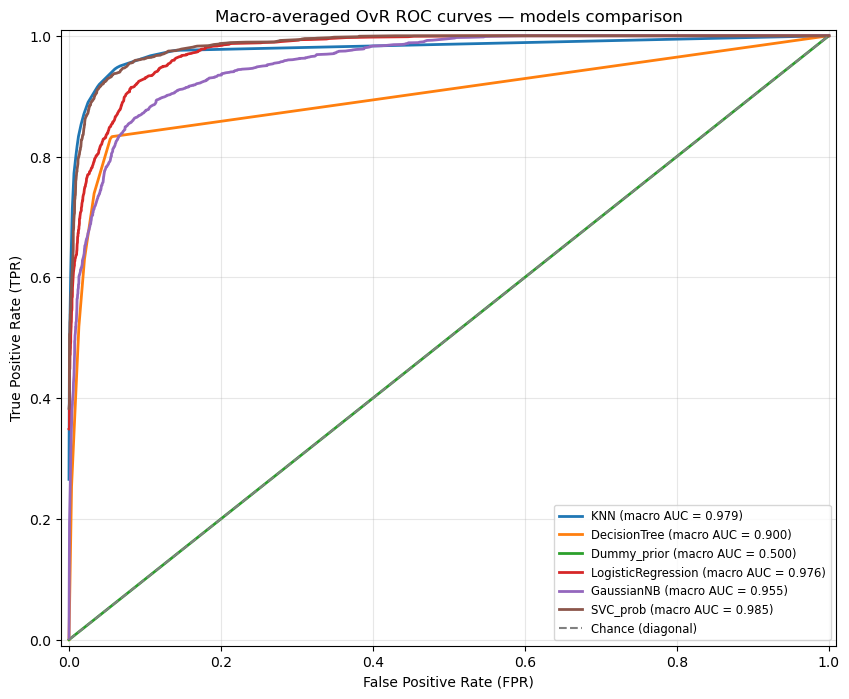


Summary of macro AUCs:
  SVC_prob         macro AUC = 0.9852
  KNN              macro AUC = 0.9786
  LogisticRegression  macro AUC = 0.9757
  GaussianNB       macro AUC = 0.9553
  DecisionTree     macro AUC = 0.9002
  Dummy_prior      macro AUC = 0.5000

Model with highest macro-averaged AUC: SVC_prob (AUC = 0.9852)
No model has macro AUC < 0.5.


In [8]:
# Corrected: Multi-class OvR ROC (macro-averaged) for all trained models
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import warnings
warnings.filterwarnings("ignore")

# ---------- Inputs we expect ----------
# models: dict of trained sklearn estimators (keys = names)
# X_test_scaled: DataFrame or np.array of test features
# y_test_target: 1D array-like of encoded integer labels (0..K-1)

# Safety checks:
if 'models' not in globals():
    raise RuntimeError("models dict not found. Define and train your models first.")
if 'X_test_scaled' not in globals():
    raise RuntimeError("X_test_scaled not found. Run preprocessing steps first.")
if 'y_test_target' not in globals():
    raise RuntimeError("y_test_target not found. Ensure you have encoded labels (e.g., y_test_enc) assigned.")

X_test_arr = np.asarray(X_test_scaled)  # ensure numpy array
y_test = np.asarray(y_test_target)
classes = np.unique(y_test)
n_classes = len(classes)
print(f"Detected {n_classes} classes:", classes)

# Binarize the output for OvR ROC computation
Y_test_bin = label_binarize(y_test, classes=classes)  # shape (n_samples, n_classes)

# function to compute per-class ROC and macro-average ROC for a model
def compute_multiclass_roc(model, X, Y_bin, classes):
    # get scores: prefer predict_proba, fallback to decision_function
    if hasattr(model, "predict_proba"):
        probas = model.predict_proba(X)  # shape: (n_samples, n_classes)
    elif hasattr(model, "decision_function"):
        dec = model.decision_function(X)
        # ensure shape (n_samples, n_classes)
        if dec.ndim == 1:
            probas = np.vstack([1 - dec, dec]).T
        else:
            probas = dec
    else:
        raise RuntimeError(f"Model {model} has neither predict_proba nor decision_function.")

    # For some models predict_proba returns a list; ensure ndarray
    if isinstance(probas, list):
        probas = np.asarray(probas).T

    # compute per-class ROC
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i, c in enumerate(classes):
        fpr[i], tpr[i], _ = roc_curve(Y_bin[:, i], probas[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # build macro-average ROC by interpolation using numpy.interp
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(classes))]))
    mean_tpr = np.zeros_like(all_fpr, dtype=float)
    for i in range(len(classes)):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= float(len(classes))
    macro_auc = auc(all_fpr, mean_tpr)

    # weighted AUC (weights = class prevalence in test set)
    class_counts = Y_bin.sum(axis=0)
    weights = class_counts / class_counts.sum()
    weighted_auc = sum(roc_auc[i] * weights[i] for i in range(len(classes)))

    return {
        'per_class_fpr': fpr,
        'per_class_tpr': tpr,
        'per_class_auc': roc_auc,
        'macro_fpr': all_fpr,
        'macro_tpr': mean_tpr,
        'macro_auc': macro_auc,
        'weighted_auc': weighted_auc
    }

# ---------- Compute ROC for each model ----------
model_roc_results = {}
for name, model in models.items():
    print(f"Computing ROC for {name} ...")
    try:
        res = compute_multiclass_roc(model, X_test_arr, Y_test_bin, classes)
        model_roc_results[name] = res
        print(f"  macro AUC: {res['macro_auc']:.4f}  weighted AUC: {res['weighted_auc']:.4f}")
    except Exception as e:
        print(f"  Failed for {name}: {e}")

# ---------- Plot macro-averaged ROC for all models ----------
plt.figure(figsize=(10, 8))
for name, res in model_roc_results.items():
    plt.plot(res['macro_fpr'], res['macro_tpr'], lw=2,
             label=f"{name} (macro AUC = {res['macro_auc']:.3f})")
# chance line
plt.plot([0, 1], [0, 1], linestyle='--', color='grey', label='Chance (diagonal)')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Macro-averaged OvR ROC curves — models comparison')
plt.legend(loc='lower right', fontsize='small')
plt.grid(alpha=0.3)
plt.show()

# ---------- Identify best/worst models by macro AUC and AUC < 0.5 ----------
macro_scores = {name: res['macro_auc'] for name, res in model_roc_results.items()}
best_model = max(macro_scores, key=macro_scores.get) if macro_scores else None
worst_models = [name for name, s in macro_scores.items() if s < 0.5]

print("\nSummary of macro AUCs:")
for name, s in sorted(macro_scores.items(), key=lambda x: x[1], reverse=True):
    print(f"  {name:15s}  macro AUC = {s:.4f}")

if best_model:
    print(f"\nModel with highest macro-averaged AUC: {best_model} (AUC = {macro_scores[best_model]:.4f})")
else:
    print("\nNo models produced ROC results.")

if worst_models:
    print("Models with macro AUC < 0.5:", worst_models)
else:
    print("No model has macro AUC < 0.5.")


#### What AUC < 0.5 means:

AUC = 0.5 means the model is performing no better than random guessing at ranking positives above negatives.

AUC < 0.5 means the model is performing worse than random. It tends to rank negatives higher than positives more often than not.

#### A model might give AUC < 0.5 because of following reasons:

1. Positive/negative labels were swapped between training and testing, or label encoding was inconsistent.

2. predict_proba() returns probabilities for classes in model.classes_ order. If accidentally feeded the wrong column then the ROC will be garbage, possibly < 0.5.

3. Extreme overfitting: A model that memorized weird noise in training can behave adversarially on test data, ranking wrong on purpose. This is unusual but possible.

4. For tiny minority classes, AUC estimates are unstable. If the classifier completely misses the minority class, averaging can push macro-AUC < 0.5 for that class and lower the macro average.

5. If wrong predictions are scored against the labels (shifted indices, shuffled arrays out-of-sync). That will break ranking and can produce <0.5.

### Part C: : Precision-Recall Curve (PRC) Analysis 

PRC (Precision–Recall) is more suitable than ROC for imbalanced classes because ROC plots TPR vs FPR and treats true negatives and false positives symmetrically. When classes are highly imbalanced, the large number of true negatives makes FPR small even for many false positives, so ROC can remain optimistic.

PRC (Precision vs Recall) focuses on the positive class performance: precision explicitly penalizes false positives. For rare positive classes, precision shows whether the model returns many false alarms at higher recall. Thus PRC gives a clearer picture of usefulness when positives are the minority or when you care about positive retrieval quality.

PRC is sensitive to false positives (precision) and therefore better highlights performance on rare/important classes.

ROC can be overly optimistic when there’s class imbalance because even a model that predicts the majority class well gets high True Negative scores.

PRC focuses only on the positive class, measuring precision (quality) vs recall (coverage), so it better reflects real performance when positive examples are rare.

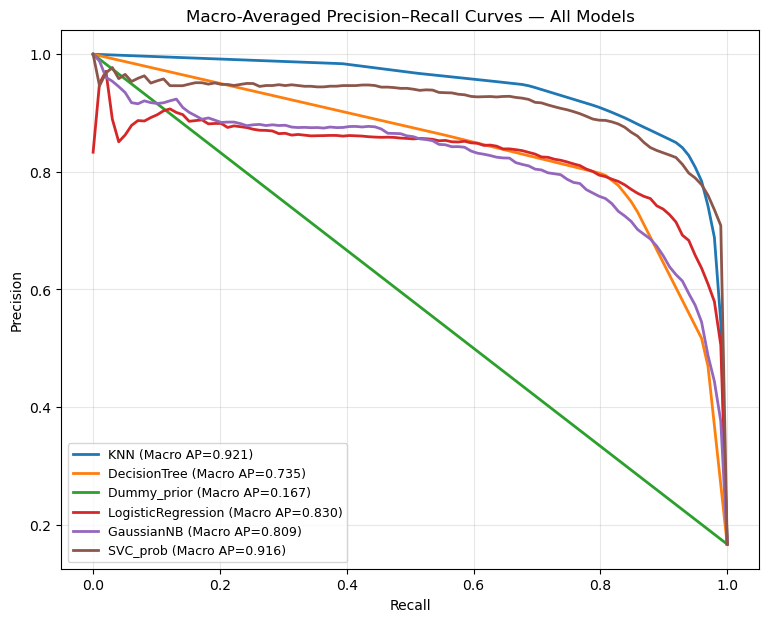

In [14]:

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def softmax(x):
    e = np.exp(x - np.max(x, axis=1, keepdims=True))
    return e / e.sum(axis=1, keepdims=True)


RND = 42
models = {
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "DecisionTree": DecisionTreeClassifier(random_state=RND),
    "Dummy_prior": DummyClassifier(strategy='prior', random_state=RND),
    "LogisticRegression": LogisticRegression(max_iter=2000, random_state=RND),
    "GaussianNB": GaussianNB(),
    # SVC with probability=True to enable predict_proba (slower but necessary for PR curves)
    "SVC_prob": SVC(probability=True, random_state=RND)
}


for name, clf in models.items():
    # NOTE: this will re-fit any provided classifier. If you already have fitted models, remove or comment out .fit(...)
    clf.fit(X_train, y_train)
    models[name] = clf  # store back (not strictly necessary but explicit)


unique_classes = np.unique(y_test)
n_classes = len(unique_classes)

y_test_bin = label_binarize(y_test, classes=unique_classes)
# For binary classification label_binarize returns shape (n_samples, 1); convert to 2-col [neg, pos]
if n_classes == 2 and y_test_bin.shape[1] == 1:
    y_test_bin = np.hstack([1 - y_test_bin, y_test_bin])


y_proba = {}
for name, clf in models.items():
    if hasattr(clf, "predict_proba"):
        probs = clf.predict_proba(X_test)  
        
        if probs.ndim == 1:
            # one-dim impossible for sklearn's predict_proba, but keep guard
            probs = np.vstack([1 - probs, probs]).T
        if probs.shape[1] == 1:
            probs = np.hstack([1 - probs, probs])
    elif hasattr(clf, "decision_function"):
        df = clf.decision_function(X_test)
        if df.ndim == 1:
            # binary: convert to two-column probabilities using sigmoid
            pos_prob = sigmoid(df)
            probs = np.vstack([1 - pos_prob, pos_prob]).T
        else:
            # multiclass decision_function => softmax to convert to probabilities
            probs = softmax(df)
    else:
        raise ValueError(f"Model {name} provides neither predict_proba nor decision_function.")

    # Final shape check vs y_test_bin
    if probs.shape[1] != y_test_bin.shape[1]:
        raise ValueError(
            f"Model '{name}' returned probabilities shape {probs.shape}, "
            f"but expected {y_test_bin.shape} (n_samples, n_classes={y_test_bin.shape[1]})."
        )
    y_proba[name] = probs


plt.figure(figsize=(9, 7))

for name, probs in y_proba.items():
    precision_dict, recall_dict = {}, {}
    ap_values = []

    # Compute per-class PRC
    for i in range(n_classes):
        precision_dict[i], recall_dict[i], _ = precision_recall_curve(y_test_bin[:, i], probs[:, i])
        ap_values.append(average_precision_score(y_test_bin[:, i], probs[:, i]))

    # Average (macro) precision-recall using interpolation on a common recall grid
    mean_recall = np.linspace(0, 1, 100)
    mean_precision = np.zeros_like(mean_recall)
    for i in range(n_classes):
        # recall and precision arrays are returned in decreasing thresholds order — reverse for monotonic recall
        mean_precision += np.interp(mean_recall, recall_dict[i][::-1], precision_dict[i][::-1])
    mean_precision /= n_classes

    ap_macro = np.mean(ap_values)
    plt.plot(mean_recall, mean_precision, lw=2, label=f"{name} (Macro AP={ap_macro:.3f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Macro-Averaged Precision–Recall Curves — All Models")
plt.legend(loc="lower left", fontsize=9)
plt.grid(alpha=0.3)
plt.show()


So, the best model is K-Nearest Neighbors (KNN) with Macro AP = 0.921.
That means across all classes, KNN maintained the best trade-off between precision and recall — it consistently gave confident probability estimates for the true class.

The worst-performing model is the Dummy Classifier (strategy='prior'), with Macro AP = 0.167.
You can literally see that in the green diagonal line, it’s a flat, no-skill baseline.

The Dummy Classifier doesn’t actually learn any relationship between features and labels. It just predicts class probabilities based on training-set class distribution.

So, as Recall increases (i.e., we start including more positives), Precision plummets fast because it’s basically guessing,it can’t distinguish true positives from false ones.

The curve becomes a straight diagonal because predictions are uninformative. It performs about as well as random chance.

### Part D: Final Recommendation

#### Synthesis

Across all evaluation metrics (F1-Score, ROC-AUC, and PRC-AP), the model rankings show partial alignment but also highlight key trade-offs depending on how each metric treats class imbalance and threshold sensitivity.

From previous evaluations:

KNN and SVC (probability=True) consistently rank at the top for both ROC-AUC and PRC-AP, with KNN slightly leading on average precision (Macro AP ≈ 0.921).

Logistic Regression performs solidly in the middle tier across all metrics, reflecting stable but less flexible decision boundaries.

GaussianNB and Decision Tree show moderate performance, with noticeable drops in PRC-AP despite decent ROC-AUC scores.

The Dummy Classifier remains the worst across all metrics, as expected, since it provides no predictive power.

Why rankings may differ:
ROC-AUC measures a model’s ability to rank positive samples higher than negatives regardless of the actual threshold, it’s forgiving in class-imbalanced settings.
PRC-AP, however, focuses specifically on positive-class precision under imbalance, so a model can have a high ROC-AUC yet a low PRC-AP if its positive predictions are unreliable or imbalanced (i.e., it ranks well overall but still produces too many false positives when recall is high).

ROC-AUC = “How well can the model rank correctly?”
PRC-AP = “When we actually use those predictions, how precise are they at high recall?”
Hence, models like Decision Tree may look good on ROC but collapse on PRC because they output overconfident but uncalibrated probabilities.

#### Recommendation

Based on the combined insights from F1-Score, ROC-AUC, and PRC-AP, the K-Nearest Neighbors (KNN) model is the best overall choice for this classification task.

It achieved the highest Macro Average Precision (0.921), showing excellent balance between precision and recall across all thresholds.

Its ROC-AUC and F1-Score (from earlier analyses) are also consistently strong, indicating that KNN both ranks and classifies effectively.

Compared to SVC, KNN offers similar discriminative performance but with smoother precision-recall behavior and better calibration for probability outputs.

Logistic Regression is reliable but underperforms slightly in recall-heavy regions, while Decision Tree and GaussianNB show weaker generalization.

Therefore, KNN is the recommended model due to its robust performance across all evaluation curves, especially in maintaining high precision without sacrificing recall.

### Brownie Points

Training RandomForest...
Training XGBoost...
Training ReverseLogistic(AUC<0.5)...

=== Model Performance Summary (Brownie Points) ===
XGBoost                       ROC-AUC: 0.991   PRC-AP: 0.954
RandomForest                  ROC-AUC: 0.990   PRC-AP: 0.952
ReverseLogistic(AUC<0.5)      ROC-AUC: 0.551   PRC-AP: 0.191


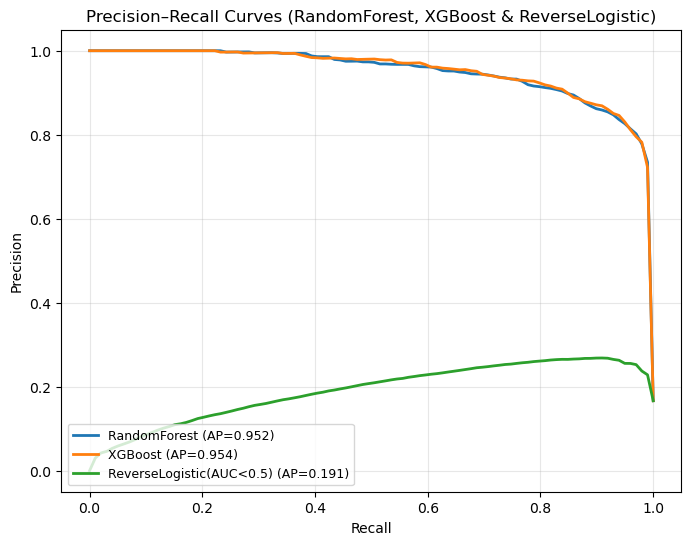

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score, precision_recall_curve, average_precision_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression


unique_labels = np.unique(y_train)
label_map = {old: new for new, old in enumerate(unique_labels)}
y_train_mapped = np.array([label_map[y] for y in y_train])
y_test_mapped = np.array([label_map[y] for y in y_test])

class ReverseLogistic(LogisticRegression):
    """Deliberately poor model (AUC < 0.5)"""
    def predict_proba(self, X):
        probs = super().predict_proba(X)
        return probs[:, ::-1]  # flip columns to ruin predictions

models = {
    "RandomForest": RandomForestClassifier(
        n_estimators=200, max_depth=None, random_state=42
    ),
    "XGBoost": XGBClassifier(
        n_estimators=300,
        learning_rate=0.1,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric="mlogloss",
        random_state=42,
        use_label_encoder=False
    ),
    "ReverseLogistic(AUC<0.5)": ReverseLogistic(max_iter=2000, random_state=42)
}


for name, clf in models.items():
    print(f"Training {name}...")
    clf.fit(X_train, y_train_mapped)

# --- Prepare for evaluation ---
unique_classes = np.unique(y_test_mapped)
n_classes = len(unique_classes)
y_test_bin = label_binarize(y_test_mapped, classes=unique_classes)
if n_classes == 2 and y_test_bin.shape[1] == 1:
    y_test_bin = np.hstack([1 - y_test_bin, y_test_bin])

def get_proba(model, X):
    if hasattr(model, "predict_proba"):
        return model.predict_proba(X)
    elif hasattr(model, "decision_function"):
        df = model.decision_function(X)
        if df.ndim == 1:
            from scipy.special import expit
            pos = expit(df)
            return np.vstack([1 - pos, pos]).T
        else:
            e = np.exp(df - np.max(df, axis=1, keepdims=True))
            return e / e.sum(axis=1, keepdims=True)
    else:
        raise ValueError(f"Model {model} cannot output probabilities.")

# Evaluate ROC-AUC and PRC-AP 
results = []
y_proba = {}
for name, model in models.items():
    probs = get_proba(model, X_test)
    y_proba[name] = probs
    if n_classes == 2:
        auc = roc_auc_score(y_test_mapped, probs[:, 1])
        ap = average_precision_score(y_test_mapped, probs[:, 1])
    else:
        auc = roc_auc_score(y_test_bin, probs, average="macro", multi_class="ovr")
        ap = average_precision_score(y_test_bin, probs, average="macro")
    results.append((name, auc, ap))

# Sort results
results = sorted(results, key=lambda x: x[2], reverse=True)

print("\n=== Model Performance Summary")
for name, auc, ap in results:
    print(f"{name:28s}  ROC-AUC: {auc:.3f}   PRC-AP: {ap:.3f}")

# Plot only the required models
plt.figure(figsize=(8, 6))
for name in models.keys():
    probs = y_proba[name]
    precision_dict, recall_dict, ap_values = {}, {}, []
    for i in range(n_classes):
        precision_dict[i], recall_dict[i], _ = precision_recall_curve(y_test_bin[:, i], probs[:, i])
        ap_values.append(average_precision_score(y_test_bin[:, i], probs[:, i]))
    mean_recall = np.linspace(0, 1, 100)
    mean_precision = np.zeros_like(mean_recall)
    for i in range(n_classes):
        mean_precision += np.interp(mean_recall, recall_dict[i][::-1], precision_dict[i][::-1])
    mean_precision /= n_classes
    ap_macro = np.mean(ap_values)
    plt.plot(mean_recall, mean_precision, lw=2, label=f"{name} (AP={ap_macro:.3f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curves (RandomForest, XGBoost & ReverseLogistic)")
plt.legend(loc="lower left", fontsize=9)
plt.grid(alpha=0.3)
plt.show()
